In [ ]:
# Import necessary libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,SimpleRNN
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model, set_random_seed
from sklearn.metrics import mean_squared_error

In [ ]:
set_random_seed(66)


 **Stock Data Analysis of the JP MORGAN stock** By <br>
Bineeth Mathew-22004878 <br>
Anns Tomy-22033815 <br>
Gobu Chettiakulam Babu-22019388 <br>
Joel Shibu-22014663 <br>
Dhanya Davis-22014216 <br>


In [ ]:
# Fetch data for a our stock, JP MORGAN, from Yahoo Finance
ticker = 'JPM'
data = yf.download(ticker, start="2018-01-01", end="2023-01-01")

[*********************100%%**********************]  1 of 1 completed


# **Data Preprocessing and Exploratory Data Analysis**


In [ ]:
# Taking a quick look at our Dataset
data.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,107.629997,108.019997,106.809998,107.949997,90.681252,13578800
2018-01-03,107.860001,108.489998,107.480003,108.059998,90.773659,11901000
2018-01-04,108.360001,110.029999,108.199997,109.040001,92.074043,12953700
2018-01-05,109.260002,109.550003,107.779999,108.339996,91.482971,14155000
2018-01-08,108.150002,108.680000,107.699997,108.500000,91.618057,12466500


In [ ]:
# View the data types and non-null values in the dataset
data.info()
data.columns

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2018-01-02 to 2022-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1259 non-null   float64
 1   High       1259 non-null   float64
 2   Low        1259 non-null   float64
 3   Close      1259 non-null   float64
 4   Adj Close  1259 non-null   float64
 5   Volume     1259 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

The dataset has 1259 rows and 6 columns. The columns are Open, High, Low,Adj close, Close, and volume. All columns have non-null values.

In [ ]:
# Doing some descriptive stats to understand the central tendancies
# and variabilities of the Data
data.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1259.000000,1259.000000,1259.000000,1259.000000,1259.000000,1.259000e+03
mean,122.973932,124.233241,121.699055,122.948689,111.666216,1.455560e+07
std,21.388094,21.422361,21.337189,21.379160,22.410515,6.674322e+06
min,81.559998,83.750000,76.910004,79.029999,70.478355,3.220500e+06
25%,108.000000,108.814999,106.605000,107.864998,93.193298,1.020565e+07
50%,115.639999,116.680000,114.669998,115.550003,104.304054,1.290460e+07
75%,137.260002,138.195000,136.184998,137.245003,127.823948,1.657100e+07
max,172.710007,172.960007,170.539993,171.779999,161.703842,5.441880e+07


In [ ]:
# Check for missing values
print(data.isnull().sum())

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


In [ ]:
# Cheking for duplicate values
duplicates = data.duplicated()

if duplicates.any():
    print("The DataFrame has duplicates.")
else:
    print("The DataFrame does not have duplicates.")

The DataFrame does not have duplicates.


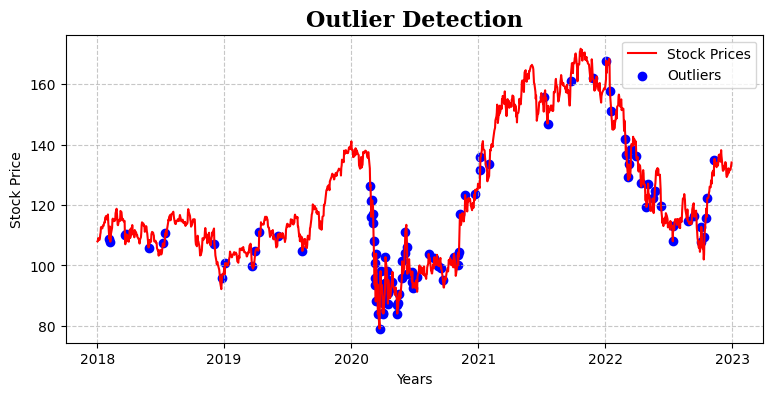

Number of outliers: 106


In [ ]:
# Outlier detection
close_prices = data['Close']
# Calculate daily returns
daily_returns = close_prices.pct_change()
# Calculating z-scores for each data point
z_scores = (daily_returns - daily_returns.mean()) / daily_returns.std()
# Set a threshold for identifying outliers
threshold = 1.5
# Identify outliers
outliers = z_scores[abs(z_scores) > threshold]

# Plot the stock prices with identified outliers
plt.figure(figsize=(9, 4))
plt.plot(close_prices.index, close_prices.values,
         label='Stock Prices', color='r')
plt.scatter(outliers.index, close_prices[outliers.index],
            color='b', label='Outliers')
plt.title('Outlier Detection', fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.xlabel('Years')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

print(f"Number of outliers: {len(outliers)}")

In [ ]:
# Handling the outliers
q1 = data['Close'].quantile(0.25)
q3 = data['Close'].quantile(0.75)
iqr = q3 - q1
upper_bound = q3 + 1.5 * iqr
data = data[data['Close'] <= upper_bound]
print("Outliers handled")
print(data)

Outliers handled
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2018-01-02  107.629997  108.019997  106.809998  107.949997   90.681252   
2018-01-03  107.860001  108.489998  107.480003  108.059998   90.773659   
2018-01-04  108.360001  110.029999  108.199997  109.040001   92.074043   
2018-01-05  109.260002  109.550003  107.779999  108.339996   91.482971   
2018-01-08  108.150002  108.680000  107.699997  108.500000   91.618057   
...                ...         ...         ...         ...         ...   
2022-12-23  130.580002  131.440002  129.639999  131.279999  127.480042   
2022-12-27  131.570007  132.220001  130.550003  131.740005  127.926727   
2022-12-28  131.850006  133.410004  131.009995  132.460007  128.625870   
2022-12-29  132.929993  133.270004  132.309998  133.220001  129.363876   
2022-12-30  132.809998  134.330002  132.440002  134.100006  130.218430   

              Volume

In [ ]:
# Extract the 'open' prices from the DataFrame
df2 = data.reset_index()['Open']
df2

0       107.629997
1       107.860001
2       108.360001
3       109.260002
4       108.150002
           ...    
1254    130.580002
1255    131.570007
1256    131.850006
1257    132.929993
1258    132.809998
Name: Open, Length: 1259, dtype: float64

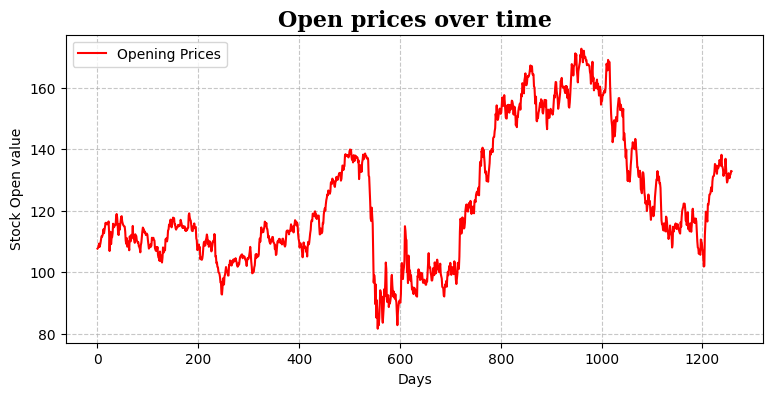

In [ ]:
# Plot the opening prices to inspect for trends
plt.figure(figsize=(9, 4))
plt.plot(df2, c='r')
# adding labels and a grid
plt.xlabel('Days')
plt.ylabel('Stock Open value')
plt.title("Open prices over time", fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.legend(['Opening Prices', 'Data Points'], loc='upper left', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)

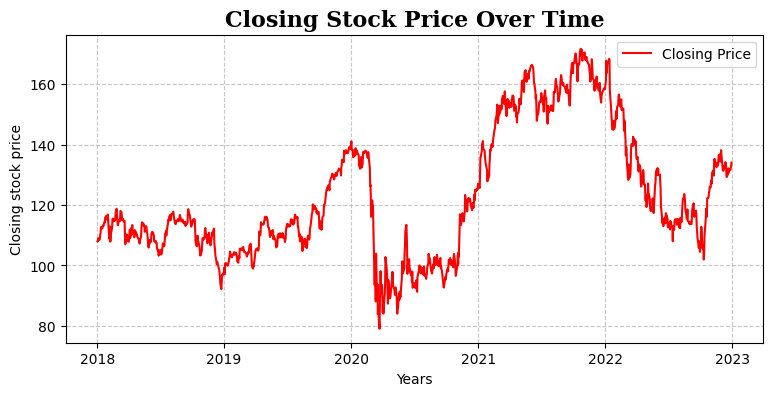

In [ ]:
# Line chart of closing stock price over time
plt.figure(figsize=(9, 4))
sns.lineplot(x='Date', y='Close', data=data, color='r', label='Closing Price')
# Title and labels
plt.title('Closing Stock Price Over Time', fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.xlabel('Years')
plt.ylabel('Closing stock price')
# Display grid
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

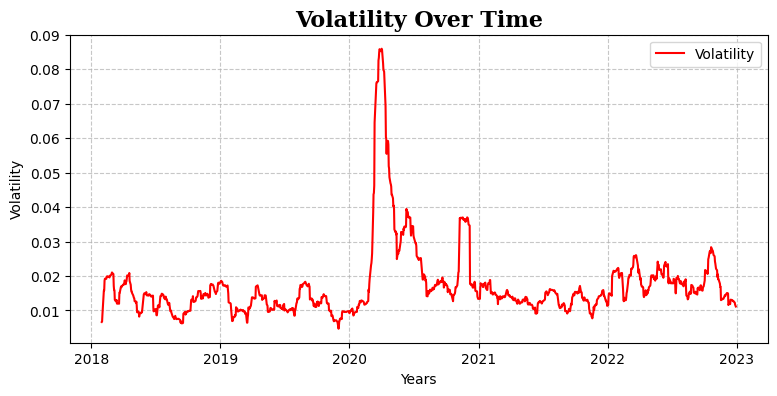

In [ ]:
# Doing a quick volatility analysis
close_prices = data['Close']
# Calculate daily returns
daily_returns = close_prices.pct_change()

# Calculating volatility as the standard deviation of
# returns over a rolling window
window_size = 20
volatility = daily_returns.rolling(window=window_size).std()

# Plot volatility over time
plt.figure(figsize=(9, 4))
plt.plot(volatility.index, volatility.values, color='red', label='Volatility')
plt.title('Volatility Over Time', fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.xlabel('Years')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()


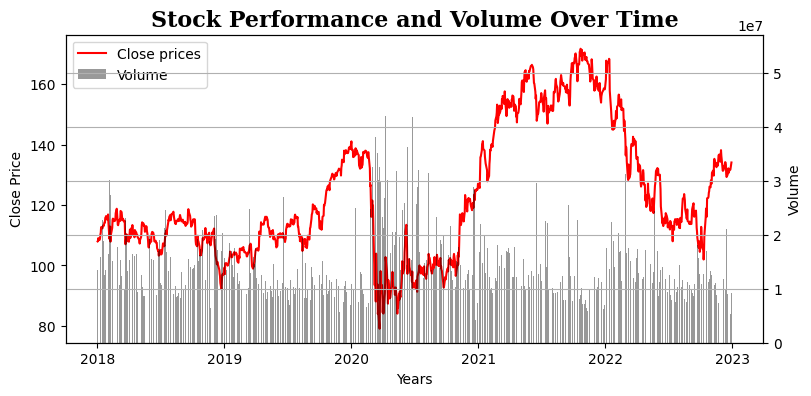

In [ ]:
###Volume data
# Extracting 'Close' prices and 'Volume' data
df_close = data['Close']
df_volume = data['Volume']

# Assuming df_close contains the 'Close' prices and df_volume
# contains the volume data
fig, ax1 = plt.subplots(figsize=(9, 4))

# Plotting the 'Close' prices on the first y-axis
ax1.plot(df_close, label='Close prices', color='red')
ax1.set_xlabel('Years')
ax1.set_ylabel('Close Price', color='black')
ax1.tick_params(axis='y', labelcolor='black')

# Creating the second y-axis for volume data
ax2 = ax1.twinx()
ax2.bar(df_volume.index, df_volume, label='Volume', color='k', alpha=0.4)
ax2.set_ylabel('Volume', color='k')
ax2.tick_params(axis='y', labelcolor='k')

# Title and legend
plt.title('Stock Performance and Volume Over Time', fontsize=16,
          fontweight='bold', fontfamily='serif')
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
lines = lines_1 + lines_2
labels = labels_1 + labels_2
ax1.legend(lines, labels, loc='upper left')
plt.grid()
# Save the plot as a high-quality image (optional)
plt.savefig('stock_performance and volume over time.png',
            dpi=300, bbox_inches='tight')
plt.show()

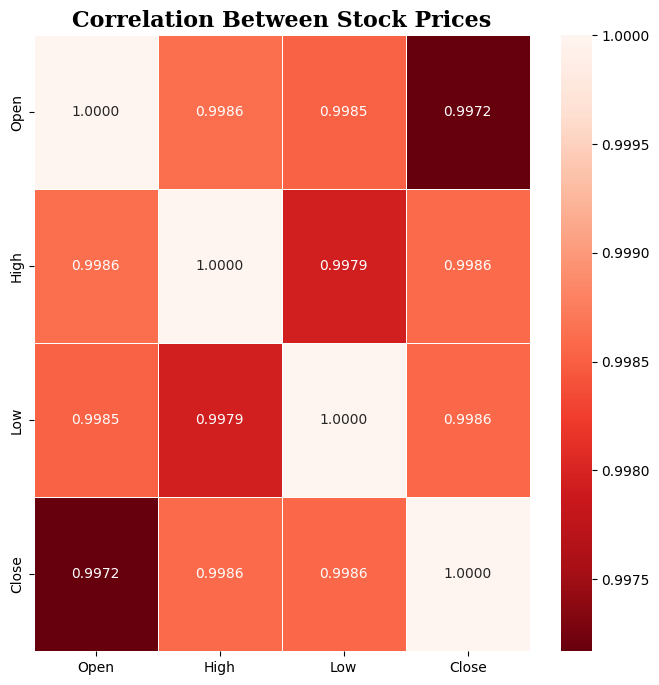

In [ ]:
# Plotting a heatmap for correlation analysis
corr = data[['Open', 'High', 'Low', 'Close']].corr()

# Create a mask to hide the upper triangle of the heatmap
mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(8, 8))
sns.heatmap(corr, annot=True, cmap='Reds_r', fmt=".4f", linewidths=.5)
plt.title('Correlation Between Stock Prices', fontsize=16,
          fontweight='bold', fontfamily='serif')
plt.show()

We can see that the opening and closing prices have a strong positive correlation, while the low and high prices have a weaker positive correlation.

In [ ]:
# Scale the data to a range between 0 and 1 as LSTMs are sensitive to scale
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1,1))

## **Building the Model**

In [ ]:
# Create the time series data structure
look_back = 50
train_size = int(len(scaled_data) * 0.80)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - look_back:]

train_generator = TimeseriesGenerator(train_data, train_data,
                                     length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(test_data, test_data,
                                     length=look_back, batch_size=1)

In [ ]:
def create_dataset(dataset, time_step = 1):
  """
  Create sequences of 'time_step' consecutive values from the input time
  series 'dataset'.
  Parameters:
  - dataset (numpy.ndarray): Input time series data.
  - time_step (int): Number of consecutive time steps in each sequence.
  Returns:
  - numpy.ndarray, numpy.ndarray: Tuple containing dataX and dataY.
  """
  dataX,dataY = [],[]
  for i in range(len(dataset)-time_step-1):
    a = dataset[i:(i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i + time_step,0])
  return np.array(dataX),np.array(dataY)

In [ ]:
# Call the function to split the data into input-output datasets
# with a time step of 50
time_step = 50
X_train,Y_train =  create_dataset(train_data,time_step)
X_test,Y_test =  create_dataset(test_data,time_step)

In [ ]:
# Display the shapes of the training and testing datasets
print(X_train.shape)
print(X_test.shape)

(956, 50)
(251, 50)


In [ ]:
# Build the RNN model
rnn_model = Sequential()
rnn_model.add(SimpleRNN(128, return_sequences=True,
                        input_shape=(X_train.shape[1],1)))
rnn_model.add(SimpleRNN(64, return_sequences=True))
rnn_model.add(SimpleRNN(32))
rnn_model.add(Dense(1))

In [ ]:
# Compile and fit RNN model
rnn_model.compile(loss = 'mean_squared_error', optimizer='adam')
rnn_model.fit(train_generator, epochs=50, batch_size=32)

Epoch 1/50
48/48 [==============================] - 11s 111ms/step - loss: 0.0769
Epoch 2/50
48/48 [==============================] - 7s 146ms/step - loss: 0.0206
Epoch 3/50
48/48 [==============================] - 5s 113ms/step - loss: 0.0040
Epoch 4/50
48/48 [==============================] - 7s 138ms/step - loss: 0.0068
Epoch 5/50
48/48 [==============================] - 5s 112ms/step - loss: 0.0047
Epoch 6/50
48/48 [==============================] - 7s 145ms/step - loss: 0.0025
Epoch 7/50
48/48 [==============================] - 5s 111ms/step - loss: 0.0036
Epoch 8/50
48/48 [==============================] - 7s 147ms/step - loss: 0.0028
Epoch 9/50
48/48 [==============================] - 5s 112ms/step - loss: 0.0018
Epoch 10/50
48/48 [==============================] - 6s 114ms/step - loss: 0.0012
Epoch 11/50
48/48 [==============================] - 6s 128ms/step - loss: 0.0018
Epoch 12/50
48/48 [==============================] - 5s 112ms/step - loss: 0.0014
Epoch 13/50
48/48 [=====

In [ ]:
# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, return_sequences=True,
                    input_shape =(X_train.shape[1],1)))
lstm_model.add(LSTM(128, return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(1))

In [ ]:
# Compile and fit LSTM model
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(train_generator, epochs=50, batch_size=32, validation_data=(X_test, Y_test))

Epoch 1/50
48/48 [==============================] - 8s 43ms/step - loss: 0.0305 - val_loss: 0.0110
Epoch 2/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0099 - val_loss: 0.0056
Epoch 3/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0064 - val_loss: 0.0132
Epoch 4/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0044 - val_loss: 0.0052
Epoch 5/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0055 - val_loss: 0.0073
Epoch 6/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0060 - val_loss: 0.0114
Epoch 7/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0047 - val_loss: 0.0052
Epoch 8/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0036 - val_loss: 0.0093
Epoch 9/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0028 - val_loss: 0.0039
Epoch 10/50
48/48 [==============================] - 1s 12ms/step - loss: 0.0022 - val_loss: 0.0058
Epoch 11/

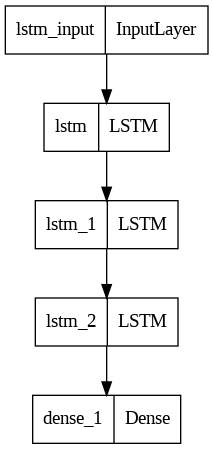

In [ ]:
plot_model(lstm_model)

In [ ]:
# Predicting on the dataset with our models
rnn_predictions = rnn_model.predict(test_generator)
lstm_predictions = lstm_model.predict(test_generator)

# Inverting out models
rnn_predictions = scaler.inverse_transform(rnn_predictions)
lstm_predictions = scaler.inverse_transform(lstm_predictions)
actual_prices = scaler.inverse_transform(test_data[look_back:])

252/252 [==============================] - 2s 5ms/step


In [ ]:
# Finding the MSE and MAE of the models

vals1 = Y_test.reshape(-1, 1)
actual_values = scaler.inverse_transform(vals1)

rnn_mse = mean_squared_error(actual_values, rnn_predictions[:-1])
lstm_mse = mean_squared_error(actual_values, lstm_predictions[:-1])
print(f'Mean Squared error of RNN Model is {rnn_mse}')
print(f'Mean Squared error of LSTM Model is {lstm_mse}')

Mean Squared error of RNN Model is 9.382554396042423
Mean Squared error of LSTM Model is 8.067205837150885


In [ ]:
rnn_mae = np.mean(np.abs(actual_values-rnn_predictions[:-1]))
lstm_mae = np.mean(np.abs(actual_values-lstm_predictions[:-1]))

print(f'Mean Absolute error of RNN Model is {rnn_mae}')
print(f'Mean Absolute error of LSTM Model is {lstm_mae}')

Mean Absolute error of RNN Model is 2.365722808229971
Mean Absolute error of LSTM Model is 2.210983823495082


Thus we can come to the consclusion that our LSTM model is a better fit than our RNN model.

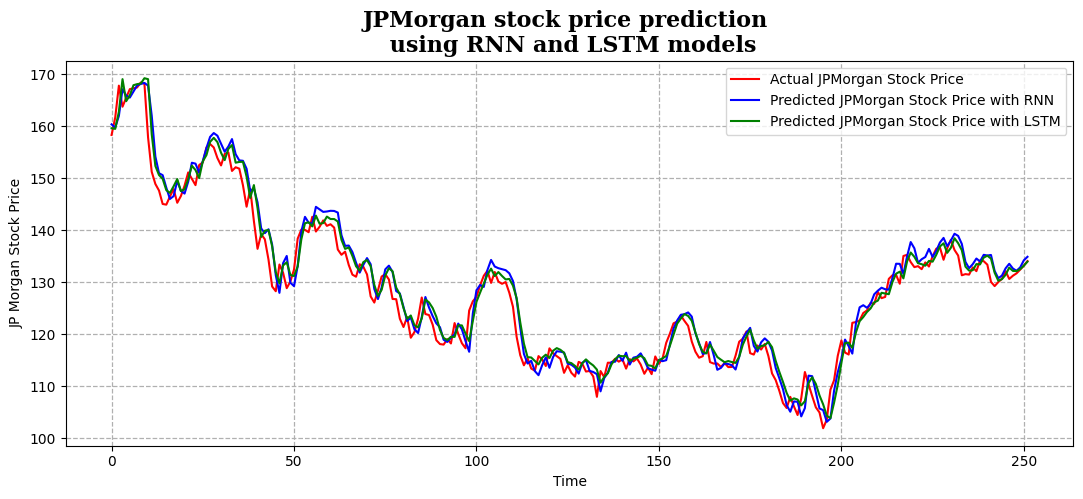

In [ ]:
# Ploting the true data along with out predictions
plt.figure(figsize=(13,5))
plt.plot(actual_prices, color='red', label='Actual JPMorgan Stock Price')
plt.plot(rnn_predictions, color='blue',
         label='Predicted JPMorgan Stock Price with RNN')
plt.plot(lstm_predictions, color='green',
         label='Predicted JPMorgan Stock Price with LSTM')
# Title, labels and legend
plt.title('JPMorgan stock price prediction \n using RNN and LSTM models',
          fontsize=16, fontweight='bold', fontfamily='serif')
plt.xlabel('Time')
plt.ylabel('JP Morgan Stock Price')
plt.grid(which='both', linestyle='--', linewidth=0.9)
plt.legend()
# Saving the plot
plt.savefig('JPMorgan stock price prediction using RNN and LSTM models.png',
            dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
def pred_future_stock(model, base_data, days_to_predict,
                      scaler, look_back=2000):
  """
  Predict future stock values using the given LSTM 'model'.
  Parameters:
  - model: Trained LSTM model.
  - base_data: Time series data used as the starting point for prediction.
  - days_to_predict: Number of future days to predict.
  - scaler: Scaler used for data normalization.
  - look_back: Number of past days to consider for each prediction.
  Returns:
  - numpy.ndarray: Predicted future stock values.
  """
  # Start with the last days of the base data
  input_data = base_data[-look_back:].reshape(1, look_back, 1)

  # Predict future days
  future_predictions = []

  for _ in range(days_to_predict):

    # Make a prediction
    prediction = model.predict(input_data)

    # Append the prediction
    future_predictions.append(prediction[0, 0])

    # Update the input data to include the prediction and
    # exclude the oldest data point.
    # Correctly reshape the prediction to
    # (1, 1, 1) before appending
    input_data = np.append(input_data[:, 1:, :],
                           prediction.reshape(1, 1, 1), axis=1)

  # Invert the scaling
  reshaped = np.array(future_predictions).reshape(-1, 1)
  future_predictions = scaler.inverse_transform(reshaped)

  return future_predictions


In [ ]:
# predicting the stock price by calling the function
days_to_pred = 25
future_days = pred_future_stock(lstm_model, scaled_data, days_to_pred,
                                scaler, look_back)
print(future_days.shape)

1/1 [==============================] - 0s 25ms/step
(25, 1)


<ipython-input-40-e0cce484039f>:2: FutureWarning: Argument `closed` is deprecated in favor of `inclusive`.
  predicted_dates = pd.date_range(start=data.index[-1],


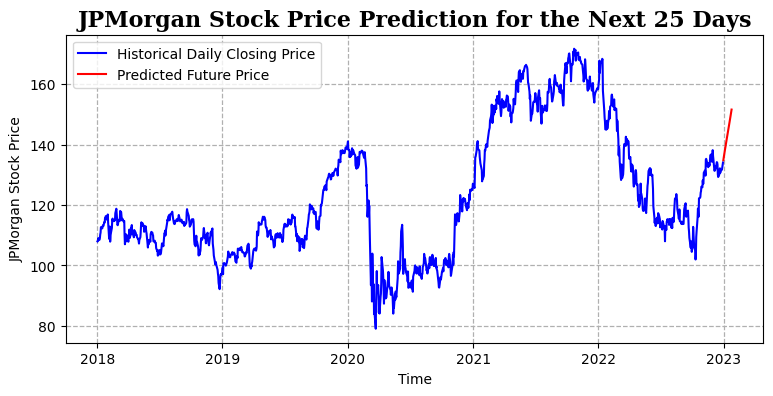

In [ ]:
# Ploting the predictions
predicted_dates = pd.date_range(start=data.index[-1],
                                periods=days_to_pred+1, closed='right')
plt.figure(figsize=(9, 4))
plt.plot(data.index, data['Close'], color='blue',
         label='Historical Daily Closing Price')
plt.plot(predicted_dates, future_days, color='red',
         label='Predicted Future Price')
# title, labels etc.
plt.title(f'JPMorgan Stock Price Prediction for the Next {days_to_pred} Days',
          fontsize=16, fontweight='bold', fontfamily='serif')
plt.xlabel('Time')
plt.ylabel('JPMorgan Stock Price')
plt.grid(which='both', linestyle='--', linewidth=0.9)
plt.legend()
plt.show()